# Load Data files and Import Python Libraries

In [1]:
import numpy as np

import pandas as pd

import os

from sklearn.feature_selection import RFE

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression

#import MatPlotLib
import matplotlib as mpl 

#Import PyPlot in MatPlotLib
import matplotlib.pyplot as plt 

#Import SciKitLearn decomposition PCA library
from sklearn.decomposition import PCA

#Import SciKitLearn dataset 
from sklearn import datasets as ds

#Allows for meterics to be found after Logistic Regression
from sklearn import metrics as mt

#Create KFolds for CV_Object
from sklearn.model_selection import StratifiedKFold

#Creates Standard Scaler Variables
from sklearn.preprocessing import StandardScaler

#Seaborn 
import seaborn as sb

directory = '//users/cmirwin/desktop/Capstone/'

if not os.path.exists(directory):
    os.makedirs(directory)

#Import Team Info
dfGameData = pd.read_csv(directory + 'GameData.csv', sep='|')

dfGameData.head()

/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


,GameID,HomeTeam,AwayTeam,GameWinner,GameLoser,ScoreHome,ScoreAway,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,...,WindChill,HeatIndex,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,HomeRushYardsPerAttempt,AwayRushYardsPerAttempt,HomeTeamWin,Degrees
0,1,PIT,TEN,PIT,TEN,13,10,19,321,6,...,NaN,NaN,9.727273,0.767442,10.636364,0.628571,1.565217,3.440000,1,67.5
1,2,ATL,MIA,ATL,MIA,19,7,19,213,4,...,NaN,NaN,9.681818,0.611111,7.761905,0.700000,2.518519,4.363636,1,90.0
2,3,BAL,KC,BAL,KC,38,24,32,303,8,...,NaN,NaN,11.653846,0.604651,9.937500,0.666667,4.829268,1.705882,1,0.0
3,4,CAR,PHI,PHI,CAR,10,38,14,83,5,...,NaN,81.0,5.928571,0.411765,4.823529,0.586207,2.866667,5.781250,0,22.5
4,5,CIN,DEN,DEN,CIN,7,12,16,221,4,...,NaN,NaN,10.523810,0.636364,13.352941,0.607143,3.185185,3.750000,0,67.5


 # Create Dummy Variables for Dataset

In [71]:
#Create new DataFrame for PCA
gameDataPCA = dfGameData

dummiesColumnToCreate = ['WindDir', 'Condition','TimeOfDay']

#Create Dummy Variables
for column in dummiesColumnToCreate:
    dummies = pd.get_dummies(gameDataPCA[str(column)]).rename(columns=lambda x: str(column) + '_' + str(x))
    #Join to Dataframe for Model
    gameDataPCA = pd.concat([gameDataPCA, dummies], axis=1)

gameDataPCA.head()
    
#Get columns that are only numeric in nature. 
columnsToDrop = ['HomeTeam', 'AwayTeam', 'GameWinner','GameLoser', 'WindDir', 'Condition','TimeOfDay', 'Date'
                 , 'HomePossTime', 'AwayPossTime']

#Drop Variables
gameDataPCA.drop(columnsToDrop, inplace=True, axis=1)

#Fill in Missing Values with 0
gameDataPCA.fillna(0, inplace=True)



# Feature Selection
## Recursive Feature Elimination

In [106]:
gameDataVariables = gameDataPCA.columns.values.tolist()
y = gameDataPCA['HomeTeamWin']
X=[i for i in gameDataVariables if i not in y]

logreg = LogisticRegression()
rfe = RFE(logreg, 18)
rfe = rfe.fit(gameDataPCA[X], y )

dfColumns = pd.DataFrame(X)

dfRankings = pd.DataFrame(rfe.ranking_)

dfColumnResults =  pd.concat([dfRankings, dfColumns], axis=1, join_axes=[dfRankings.index])

dfColumnResults.columns = ['Value', 'ColumnName']

dfColumnsForModel = dfColumnResults[dfColumnResults['Value'] == 1]

print dfColumnsForModel['ColumnName'].values

['GameID' 'ScoreHome' 'ScoreAway' 'HomePassingYards' 'HomePuntAvg'
 'HomePuntYards' 'HomeRushingYards' 'HomeTotalYards' 'AwayPassingYards'
 'AwayPenaltyYards' 'AwayPuntYards' 'AwayRushingYards' 'Year' 'NumericDate'
 'Temp' 'DewPoint' 'Humidity' 'Degrees']


## PCA Analysis

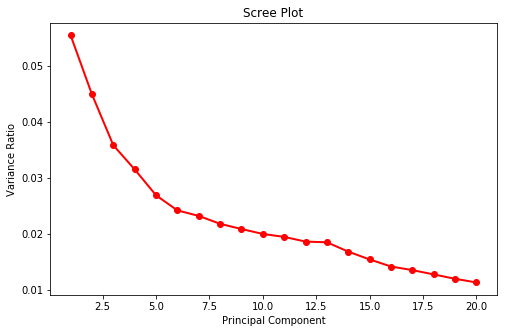

In [73]:
#This section scales the data in order to create a more useable data set
# scale attributes by the training set
stdsclrObj = StandardScaler()

# find scalings for each column that make this zero mean and unit std
#We use the training data to help fit the standard dev
# find scalings for each column that make this zero mean and unit std
stdsclrObj.fit(gameDataPCA) 

# to transform new feature data
# apply to training
gameData_scaled = stdsclrObj.transform(gameDataPCA)

components = 20

pca = PCA(n_components= components)

#Run PCA
# fit data and then transform it
gameData_pca = pca.fit(gameData_scaled).transform(gameData_scaled) 

variance_ratio = pca.explained_variance_ratio_

fig = plt.figure(figsize=(8,5))
#Create 
CompentValues = np.arange(components) + 1
plt.plot(CompentValues, variance_ratio, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.show()

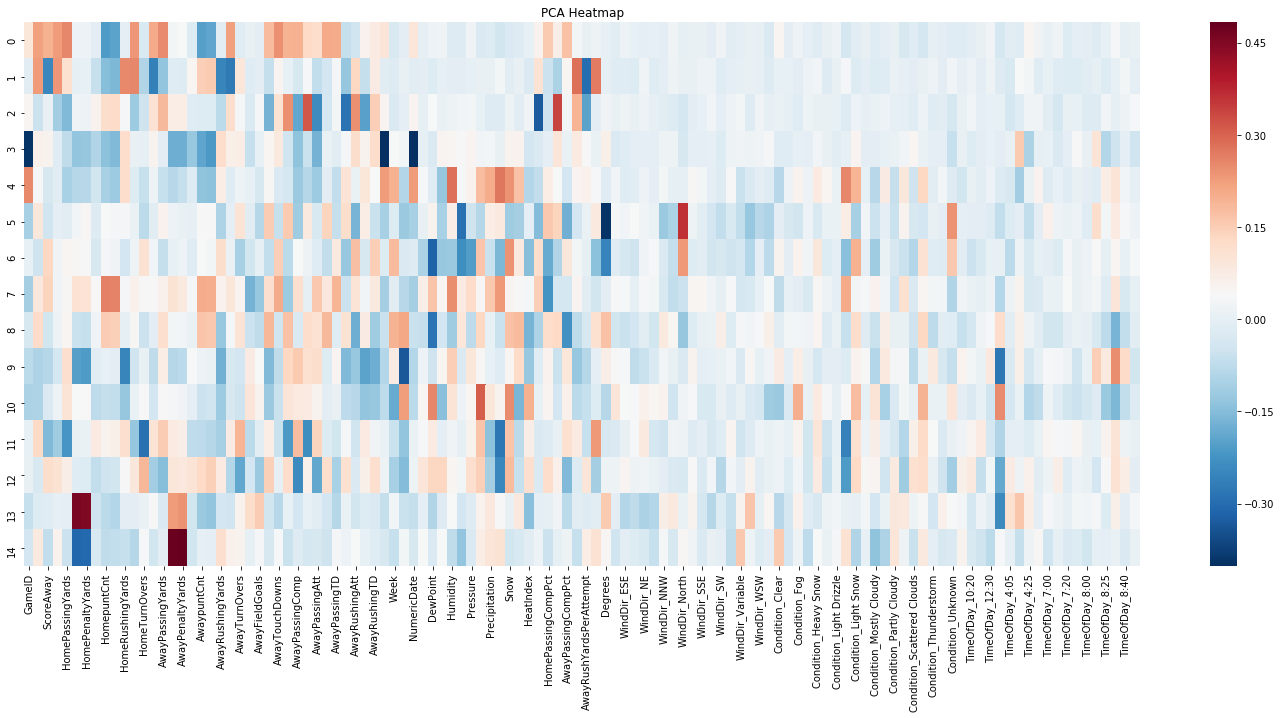

In [74]:
pca_components = pca.components_

compValues = pd.DataFrame(pca_components,columns=gameDataPCA.columns)

#show top 40 vectors due to the analysis 
compValues = compValues[compValues.index < 15]

plt.figure(figsize=(25,10))

plt.title('PCA Heatmap')

sb.heatmap(compValues, cmap = 'RdBu_r', cbar=True)

plt.show()

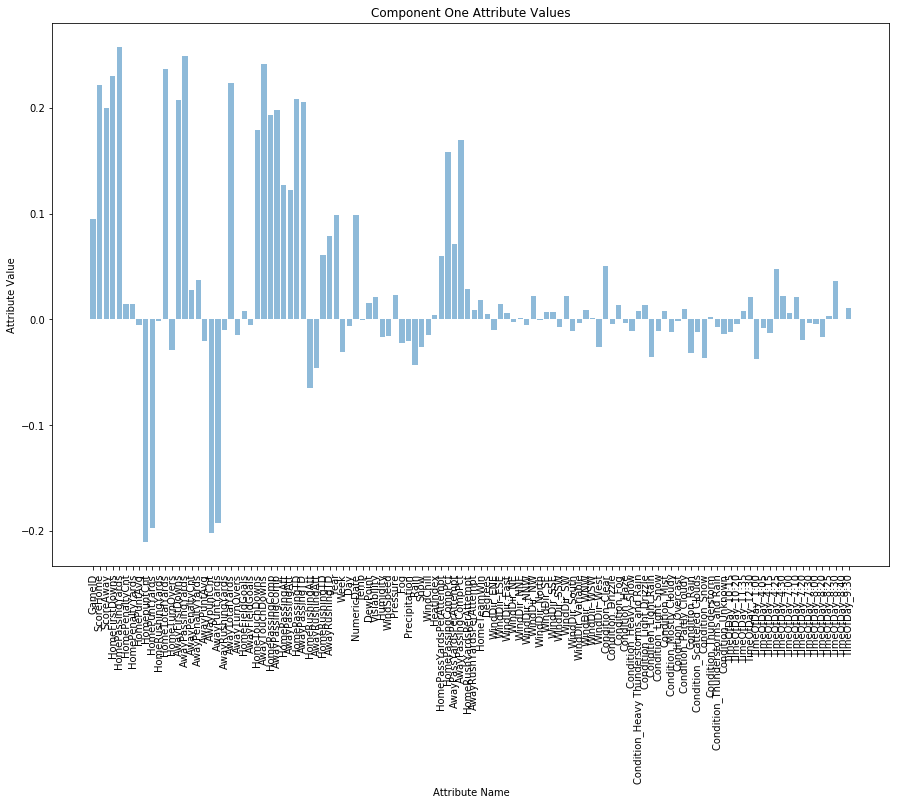

In [75]:
compValuesTransformed = compValues.T

#print (compValuesTransformed[0])

fig = plt.figure(figsize=(15,10))
#Create
objects = compValuesTransformed.index
y_pos = np.arange(len(objects)) + 1
performance = compValuesTransformed[0]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90)
plt.xlabel('Attribute Name')
plt.ylabel('Attribute Value')
plt.title('Component One Attribute Values')

plt.show()

# Creating Logistic Regression Model
https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Create X and Y for model using all columns 

In [78]:
dfValuesForRegression = pd.DataFrame()

for column in gameDataPCA.columns:
    if column not in ('ScoreHome', 'ScoreAway', 'HomeTeamWin'):
        dfValuesForRegression[column] = gameDataPCA[[column]] 

y = gameDataPCA['HomeTeamWin']

XFull = dfValuesForRegression

XFull.head()

,GameID,HomeFirstDowns,HomePassingYards,HomePenaltyCnt,HomePenaltyYards,HomePuntAvg,HomepuntCnt,HomePuntYards,HomeRushingYards,HomeTotalYards,...,TimeOfDay_7:00,TimeOfDay_7:10,TimeOfDay_7:20,TimeOfDay_7:30,TimeOfDay_8:00,TimeOfDay_8:20,TimeOfDay_8:25,TimeOfDay_8:30,TimeOfDay_8:40,TimeOfDay_9:30
0,1,19,321,6,60,41,7,299,36,357,...,0,0,0,0,0,0,0,1,0,0
1,2,19,213,4,35,31,4,155,68,281,...,0,0,0,0,0,0,0,0,0,0
2,3,32,303,8,65,29,3,87,198,501,...,0,0,0,0,0,0,0,0,0,0
3,4,14,83,5,30,19,4,223,86,169,...,0,0,0,0,0,0,0,0,0,0
4,5,16,221,4,27,37,7,278,86,307,...,0,0,0,0,0,0,0,0,0,0


## Create X and Y for  Recursive

In [108]:
dfRecursiveForRegression = pd.DataFrame()

for column in dfColumnsForModel['ColumnName'].values:
    if column not in ('ScoreHome', 'ScoreAway', 'HomeTeamWin'):
        dfRecursiveForRegression[column] = gameDataPCA[[column]] 

y = gameDataPCA['HomeTeamWin']

XRecursive = dfRecursiveForRegression

XRecursive.head()

,GameID,HomePassingYards,HomePuntAvg,HomePuntYards,HomeRushingYards,HomeTotalYards,AwayPassingYards,AwayPenaltyYards,AwayPuntYards,AwayRushingYards,Year,NumericDate,Temp,DewPoint,Humidity,Degrees
0,1,321,41,299,36,357,234,28,223,86,2009,20090910,63.0,48.9,60.0,67.5
1,2,213,31,155,68,281,163,27,225,96,2009,20090913,79.0,63.0,58.0,90.0
2,3,303,29,87,198,501,159,15,246,29,2009,20090913,79.0,55.9,45.0,0.0
3,4,83,19,223,86,169,82,76,171,185,2009,20090913,81.0,57.0,44.0,22.5
4,5,221,37,278,86,307,227,39,340,75,2009,20090913,75.9,50.0,40.0,67.5


## Create data set for PCA Values

In [109]:
#Get All PCA Data
dfPCAValues = pd.DataFrame(performance)

#Set Column Names for dataframe created above
dfPCAValues.columns = ['values']

#Get all Columns with an absolute value greater than .05
dfColumnNamesForRegression = dfPCAValues[abs(dfPCAValues['values']) > .05]

#Create new Data frame with Correct Column Names.
dfColumnName = pd.DataFrame(dfColumnNamesForRegression.index, columns = ['ColumnName'])

#Create empty dataFrame for column values
dfColValuesForRegression = pd.DataFrame()

#Fill new dataFrame
for column in dfColumnName.values:
    insertColumn = column[-1]
    if insertColumn not in ('ScoreHome', 'ScoreAway'):
        dfColValuesForRegression[insertColumn] = gameDataPCA[[insertColumn]] 
    
y = gameDataPCA['HomeTeamWin']

XPCA = dfColValuesForRegression

XPCA.head()

,GameID,HomeFirstDowns,HomePassingYards,HomepuntCnt,HomePuntYards,HomeTotalYards,AwayFirstDowns,AwayPassingYards,AwaypuntCnt,AwayPuntYards,...,HomeRushingAtt,HomeRushingTD,AwayRushingTD,Year,NumericDate,HomePassYardsPerAttempt,HomePassingCompPct,AwayPassYardsPerAttempt,AwayPassingCompPct,Condition_Clear
0,1,19,321,7,299,357,18,234,5,223,...,23,0,0,2009,20090910,9.727273,0.767442,10.636364,0.628571,1
1,2,19,213,4,155,281,16,163,5,225,...,27,0,0,2009,20090913,9.681818,0.611111,7.761905,0.700000,1
2,3,32,303,3,87,501,11,159,5,246,...,41,2,0,2009,20090913,11.653846,0.604651,9.937500,0.666667,0
3,4,14,83,4,223,169,17,82,4,171,...,30,1,1,2009,20090913,5.928571,0.411765,4.823529,0.586207,0
4,5,16,221,7,278,307,10,227,8,340,...,27,1,0,2009,20090913,10.523810,0.636364,13.352941,0.607143,1


## Create Model and Cross Validation Object

In [110]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.model_selection import ShuffleSplit

# first we create a reusable logisitic regression object
# get object
lr_clf = LogisticRegression(penalty='l1', C=1.0, class_weight=None) 
   
#Create CV_Object
cv_object = ShuffleSplit(n_splits=5,
                         test_size  = .2)

## Cross Validation for Full Dataset model

In [111]:
# train object
lr_clf.fit(XFull,y)

# get test set precitions
y_hat = lr_clf.predict(XFull) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("==== Model Fit Full Data Set ====")
print("accuracy", acc )
print("confusion matrix\n",conf)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XFull,y): 
  
    #Create Training DataSet
    X_train = XFull.loc[XFull.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = XFull.loc[XFull.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clf.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clf.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("==== Cross Validation Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    

==== Model Fit Full Data Set ====
('accuracy', 0.84887962480458568)
('confusion matrix\n', array([[677, 157],
       [133, 952]]))
('==== Cross Validation Iteration', 1, ' ====')
('accuracy', 0.8359375)
('confusion matrix\n', array([[147,  34],
       [ 29, 174]]))
('==== Cross Validation Iteration', 2, ' ====')
('accuracy', 0.81770833333333337)
('confusion matrix\n', array([[141,  32],
       [ 38, 173]]))
('==== Cross Validation Iteration', 3, ' ====')
('accuracy', 0.80729166666666663)
('confusion matrix\n', array([[142,  41],
       [ 33, 168]]))
('==== Cross Validation Iteration', 4, ' ====')
('accuracy', 0.85416666666666663)
('confusion matrix\n', array([[141,  25],
       [ 31, 187]]))
('==== Cross Validation Iteration', 5, ' ====')
('accuracy', 0.8359375)
('confusion matrix\n', array([[131,  37],
       [ 26, 190]]))


## Model and Cross Validation for PCA Suggestions

In [112]:
# train object
lr_clf.fit(XPCA,y)

# get test set precitions
y_hat = lr_clf.predict(XPCA) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("==== Model Fit PCA Data Set ====")
print("accuracy", acc )
print("confusion matrix\n",conf)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XPCA,y): 
  
    #Create Training DataSet
    X_train = XPCA.loc[XPCA.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = XPCA.loc[XPCA.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clf.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clf.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("==== Cross Validation Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

==== Model Fit PCA Data Set ====
('accuracy', 0.69202709744658675)
('confusion matrix\n', array([[491, 343],
       [248, 837]]))
('==== Cross Validation Iteration', 1, ' ====')
('accuracy', 0.6953125)
('confusion matrix\n', array([[108,  65],
       [ 52, 159]]))
('==== Cross Validation Iteration', 2, ' ====')
('accuracy', 0.67447916666666663)
('confusion matrix\n', array([[ 90,  58],
       [ 67, 169]]))
('==== Cross Validation Iteration', 3, ' ====')
('accuracy', 0.7109375)
('confusion matrix\n', array([[ 96,  70],
       [ 41, 177]]))
('==== Cross Validation Iteration', 4, ' ====')
('accuracy', 0.68229166666666663)
('confusion matrix\n', array([[ 90,  62],
       [ 60, 172]]))
('==== Cross Validation Iteration', 5, ' ====')
('accuracy', 0.68489583333333337)
('confusion matrix\n', array([[100,  74],
       [ 47, 163]]))


## Create Model for Recursive Data 

In [113]:
lr_clf.fit(XRecursive,y)

# get test set precitions
y_hat = lr_clf.predict(XRecursive) 

#print('Intercept: ', clf.intercept_, 'Coeffiencts: ', clf.coef_)

#Get Accuracy_Score and Confusion Matrix
acc = mt.accuracy_score(y,y_hat)
conf = mt.confusion_matrix(y,y_hat)
print("==== Model Fit Recursive Data Set ====")
print("accuracy", acc )
print("confusion matrix\n",conf)

iter_num = 1
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(XRecursive,y): 
  
    #Create Training DataSet
    X_train = XRecursive.loc[XRecursive.index.isin(train_indices)]
    y_train = y.loc[y.index.isin(train_indices)] 
    
    #Create Testing DataSet
    X_test = XRecursive.loc[XRecursive.index.isin(test_indices)]
    y_test = y.loc[y.index.isin(test_indices)]
    
    # train object
    lr_clf.fit(X_train,y_train)
    
    # get test set precitions
    y_hat = lr_clf.predict(X_test) 

    #Get Accuracy_Score and Confusion Matrix
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("==== Cross Validation Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

==== Model Fit Recursive Data Set ====
('accuracy', 0.70401250651380931)
('confusion matrix\n', array([[506, 328],
       [240, 845]]))
('==== Cross Validation Iteration', 1, ' ====')
('accuracy', 0.71614583333333337)
('confusion matrix\n', array([[ 98,  67],
       [ 42, 177]]))
('==== Cross Validation Iteration', 2, ' ====')
('accuracy', 0.703125)
('confusion matrix\n', array([[101,  65],
       [ 49, 169]]))
('==== Cross Validation Iteration', 3, ' ====')
('accuracy', 0.65885416666666663)
('confusion matrix\n', array([[ 88,  73],
       [ 58, 165]]))
('==== Cross Validation Iteration', 4, ' ====')
('accuracy', 0.70052083333333337)
('confusion matrix\n', array([[ 99,  58],
       [ 57, 170]]))
('==== Cross Validation Iteration', 5, ' ====')
('accuracy', 0.70052083333333337)
('confusion matrix\n', array([[ 99,  67],
       [ 48, 170]]))
